In [1]:
import numpy  as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import scipy.stats

In [2]:
df = pd.read_pickle("/glade/work/hpzhang/LCC_pred/data/data_monthly.pkl").dropna()
df = df[df.index.year.isin(np.arange(2015,2019))]

pred_XGB    = np.load('/glade/work/hpzhang/LCC_pred/data/XGB/y_pred_XGB.npy')
pred_NN  = np.load('/glade/work/hpzhang/LCC_pred/data/NN/y_pred_neural.npy')
pred_Qu    = np.load('/glade/work/hpzhang/LCC_pred/data/Qu/y_pred_lr.npy')

In [3]:
df.head()

lat  lon  lsm       LCF       T1000        T700      TH1000  \
time                                                                       
2015-01-15 -59.5  0.5  0.0  0.463868  273.248932  257.640778  273.248932   
2015-01-15 -59.5  1.5  0.0  0.463868  273.248932  257.677979  273.248932   
2015-01-15 -59.5  2.5  0.0  0.429262  273.243439  257.717896  273.243439   
2015-01-15 -59.5  3.5  0.0  0.429262  273.237915  257.761963  273.237915   
2015-01-15 -59.5  4.5  0.0  0.427947  273.237915  257.800537  273.237915   

                 TH850       TH700     RH1000  ...         LH        SH  \
time                                           ...                        
2015-01-15  276.122772  285.309723  74.363846  ... -27.085648 -4.329421   
2015-01-15  276.148712  285.350922  74.302193  ... -26.748310 -4.402477   
2015-01-15  276.157379  285.395111  74.627144  ... -25.706528 -3.955046   
2015-01-15  276.161713  285.443909  74.877113  ... -25.131065 -3.863727   
2015-01-15  276.212219  285.486633  75.538681  ... -25.160833 -4.320301   

                   SST      Tadv     AOD        dQ        LTS       EIS  \
time                                                                      
2015-01-15  273.818970  0.004144  0.1830  0.001957  12.060791  5.536515   
2015-01-15  273.810089  0.017093  0.1500  0.001953  12.101990  5.572093   
2015-01-15  273.756317 -0.045310  0.1405  0.001963  12.151672  5.616665   
2015-01-15  273.736786 -0.162998  0.1455  0.001953  12.205994  5.665254   
2015-01-15  273.761627 -0.077789  0.1295  0.001952  12.248718  5.702139   

               ECTEI       ELF  
time                            
2015-01-15  4.415848  0.842661  
2015-01-15  4.453444  0.843229  
2015-01-15  4.492636  0.847486  
2015-01-15  4.546604  0.851414  
2015-01-15  4.584386  0.859509  

[5 rows x 30 columns]

In [4]:
df_new = pd.DataFrame({'lat':df['lat'],
                       'lon':df['lon'],
                       'LCF':df['LCF'],
                       'EIS':df['EIS'],
                       'ECTEI':df['ECTEI'],
                       'ELF':df['ELF'],
                       'y_pred_Qu':pred_Qu,
                       'y_pred_XGB':pred_XGB,
                       'y_pred_NN':pred_NN.flatten(),
                      }, index=df.index)

In [5]:
def get_rmse(df):
    x1 = mean_squared_error(df['LCF'], df['y_pred_Qu'], squared=False)
    x2 = mean_squared_error(df['LCF'], df['y_pred_XGB'],squared=False)
    x3 = mean_squared_error(df['LCF'], df['y_pred_NN'], squared=False)
    
    res = pd.DataFrame({'val':[x1,x2,x3]},
                        index=pd.Series(['Qu','XGBoost','NN'], name='model'))
    return(res)

def get_mae(df):
    x1 = mean_absolute_error(df['LCF'], df['y_pred_Qu'])
    x2 = mean_absolute_error(df['LCF'], df['y_pred_XGB'])
    x3 = mean_absolute_error(df['LCF'], df['y_pred_NN'])
    
    res = pd.DataFrame({'val':[x1,x2,x3]},
                        index=pd.Series(['Qu','XGBoost','NN'], name='model'))
    return(res)
def get_cor(df):
    x1, y1 = scipy.stats.pearsonr(df['LCF'], df['EIS'])
    x2, y2 = scipy.stats.pearsonr(df['LCF'], df['ECTEI'])
    x3, y3 = scipy.stats.pearsonr(df['LCF'], df['ELF'])
    
    x4, y4 = scipy.stats.pearsonr(df['LCF'], df['y_pred_Qu'])
    x5, y5 = scipy.stats.pearsonr(df['LCF'], df['y_pred_XGB'])
    x6, y6 = scipy.stats.pearsonr(df['LCF'], df['y_pred_NN'])
    
    res = pd.DataFrame({'r':[x1,x2,x3,x4,x5,x6],
                        'p':[y1,y2,y3,y4,y5,y6]},
                        index=pd.Series(['EIS','ECTEI','ELF','Qu','XGBoost','NN'], name='model'))
    return(res)

In [6]:
rmse_space = df_new.groupby(['lat','lon']).apply(get_rmse)
rmse_space.reset_index(level=[0,1,2], inplace=True)

mae_space = df_new.groupby(['lat','lon']).apply(get_mae)
mae_space.reset_index(level=[0,1,2], inplace=True)

print(rmse_space.groupby('model').quantile([.05, .25, .5, .95]))
print(mae_space.groupby('model').quantile([.05, .25, .5, .95]))

               lat    lon       val
model                              
NN      0.05 -55.5   32.5  0.030192
        0.25 -39.5  123.5  0.041190
        0.50 -12.5  198.5  0.048482
        0.95  48.5  342.5  0.076230
Qu      0.05 -55.5   32.5  0.047307
        0.25 -39.5  123.5  0.059339
        0.50 -12.5  198.5  0.070053
        0.95  48.5  342.5  0.157022
XGBoost 0.05 -55.5   32.5  0.031464
        0.25 -39.5  123.5  0.043007
        0.50 -12.5  198.5  0.050373
        0.95  48.5  342.5  0.079436
               lat    lon       val
model                              
NN      0.05 -55.5   32.5  0.023584
        0.25 -39.5  123.5  0.032352
        0.50 -12.5  198.5  0.038360
        0.95  48.5  342.5  0.059984
Qu      0.05 -55.5   32.5  0.037537
        0.25 -39.5  123.5  0.047593
        0.50 -12.5  198.5  0.056461
        0.95  48.5  342.5  0.128874
XGBoost 0.05 -55.5   32.5  0.024356
        0.25 -39.5  123.5  0.033733
        0.50 -12.5  198.5  0.039991
        0.95  48.5  342.5  0

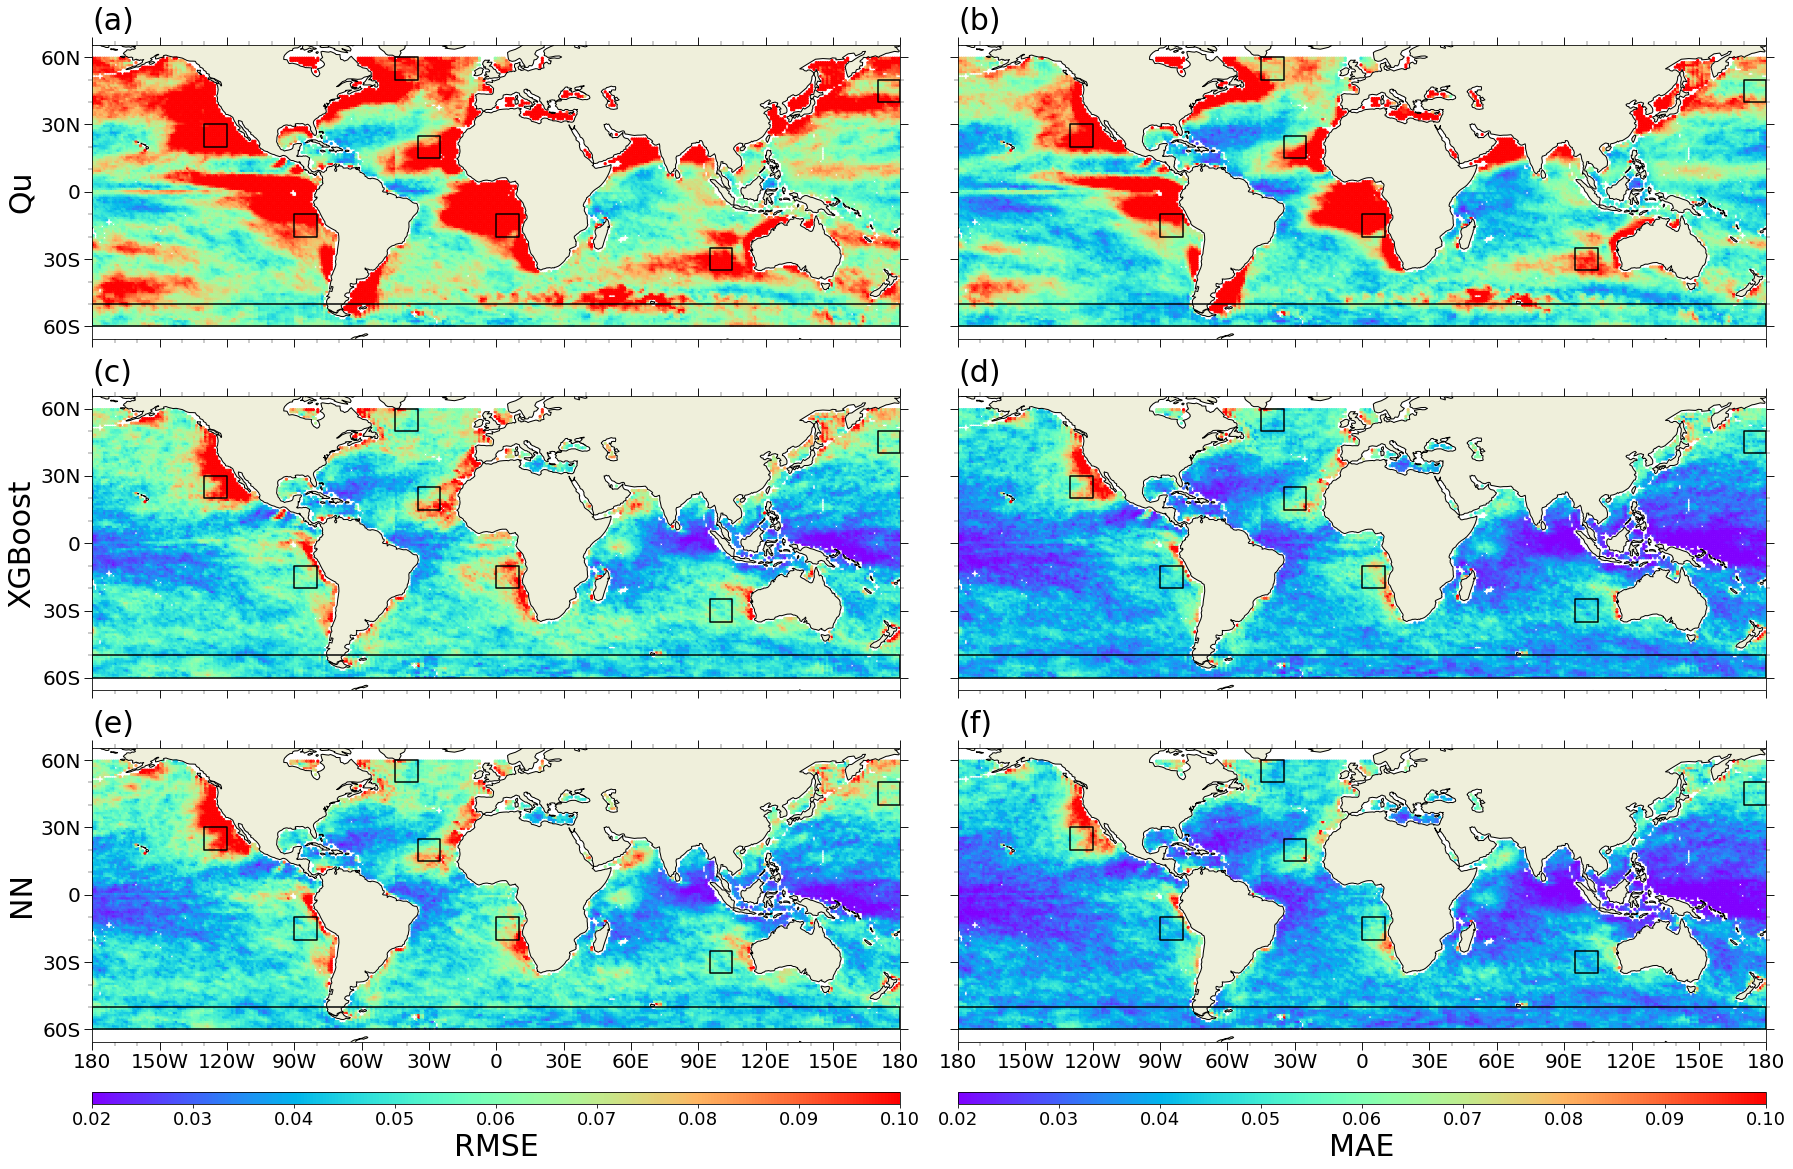

In [7]:
plt_dat1 = rmse_space[rmse_space.model=='Qu']
plt_dat2 = rmse_space[rmse_space.model=='XGBoost']
plt_dat3 = rmse_space[rmse_space.model=='NN']

plt_dat4 = mae_space[mae_space.model=='Qu']
plt_dat5 = mae_space[mae_space.model=='XGBoost']
plt_dat6 = mae_space[mae_space.model=='NN']

plt_dats = [plt_dat1, plt_dat2, plt_dat3, plt_dat4, plt_dat5, plt_dat6]

import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import cm
import cartopy.feature as cfeature
import geocat.viz.util as gvutil
from shapely.geometry.polygon import LinearRing

fig = plt.figure(figsize=(30, 30))

projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
axgr = AxesGrid(fig,
                111,
                axes_class=axes_class,
                nrows_ncols=(3, 2),
                axes_pad=0.8,
                share_all=True,
                cbar_location="bottom",
                cbar_mode='edge',
                direction = 'column',
                cbar_pad=0.7,
                cbar_size='4.0%',
                label_mode=''
                )  # note the empty label_mode


# Create a dictionary for common plotting options for both subplots
plot_option1 = dict(transform=projection,
                    cmap=cm.rainbow,
                    vmin=0.02,
                    vmax=0.10,
                    )
plot_option2 = dict(transform=projection,
                    cmap=cm.rainbow,
                    vmin=0.02,
                    vmax=0.10,
                    )

def get_box(lon, lat):
    lons = [lon[0], lon[1], lon[1], lon[0]]
    lats = [lat[0], lat[0], lat[1], lat[1]]
    ring = LinearRing(list(zip(lons, lats)))
    return(ring)

ring1 = get_box([-90,-80], [-20, -10]) # Peruvian
ring2 = get_box([0, 10], [-20, -10])   # Namibian
ring3 = get_box([-130,-120], [20, 30]) # Californian
ring4 = get_box([95,105], [-35,-25])   # Australian
ring5 = get_box([-35, -25], [15, 25])  # Canarian

ring6 = get_box([170,180], [40,50])  # North Pacific
ring7 = get_box([-45,-35], [50,60])    # North Atlantic
ring8 = get_box([-180,180], [-60,-50]) # Circumpolar Ocean

ring = [ring1, ring2, ring3, ring4, ring5, ring6, ring7, ring8]
ti = ['(a)', '(c)', '(e)', '(b)', '(d)', '(f)']

for i, (ax,plt_dat) in enumerate(zip(axgr,plt_dats)):

    if i <= 2:
        p = ax.scatter(plt_dat.lon, plt_dat.lat, c=plt_dat.val, s=5, **plot_option1)
    else:
        p = ax.scatter(plt_dat.lon, plt_dat.lat, c=plt_dat.val, s=5, **plot_option2)
    ax.annotate(ti[i], xy=(0.00, 1.05), xycoords='axes fraction', fontsize=30)
    
    if i==0:
        ax.set_ylabel('Qu', fontsize=30)
    if i==1:
        ax.set_ylabel('XGBoost', fontsize=30)
    if i==2:
        ax.set_ylabel('NN', fontsize=30)
        
    if i <=1 or i == 3 or i == 4:
        plt.setp(ax.get_xticklabels(), visible=False)
    if i > 2:
        plt.setp(ax.get_yticklabels(), visible=False)
    
    # set colorbars
    if i == 2 or i == 5:
        ax.cax.colorbar(p)
    
    # plot boxes
    for ir in range(len(ring)):
        ax.add_geometries([ring[ir]], crs=projection, facecolor='none', edgecolor='black', lw=1.5)

    ax.coastlines()
    ax.add_feature(cfeature.LAND)

    gvutil.add_major_minor_ticks(ax, labelsize=20)

    gvutil.set_axes_limits_and_ticks(ax,
                                     xticks=np.linspace(-180, 180, 13),
                                     yticks=np.linspace(-60, 60, 5))

    ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))
    ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol=''))

    
for i, cax in enumerate(axgr.cbar_axes):
    cax.toggle_label(True)
    axis = cax.axis[cax.orientation]
    axis.label.set_size(30)
    axis.major_ticklabels.set_size(18)
  
    if i==0:
        axis.label.set_text(r'RMSE')
    else:
        axis.label.set_text(r'MAE')        

       


In [8]:
cor_space = df_new.groupby(['lat','lon']).apply(get_cor)
cor_space.reset_index(level=[0,1,2], inplace=True)

print(cor_space.groupby('model').quantile([.05, .25, .5, .95]))

               lat    lon         r             p
model                                            
ECTEI   0.05 -55.5   32.5 -0.096061  1.188471e-13
        0.25 -39.5  123.5  0.360904  2.363452e-08
        0.50 -12.5  198.5  0.564648  3.500603e-05
        0.95  48.5  342.5  0.837455  5.533580e-01
EIS     0.05 -55.5   32.5  0.060756  2.176126e-14
        0.25 -39.5  123.5  0.411992  4.538334e-09
        0.50 -12.5  198.5  0.600871  8.954215e-06
        0.95  48.5  342.5  0.850132  4.568426e-01
ELF     0.05 -55.5   32.5  0.063083  8.501566e-15
        0.25 -39.5  123.5  0.429153  4.597217e-09
        0.50 -12.5  198.5  0.600317  8.537709e-06
        0.95  48.5  342.5  0.856463  4.449743e-01
NN      0.05 -55.5   32.5  0.565671  3.617887e-25
        0.25 -39.5  123.5  0.735493  9.579505e-18
        0.50 -12.5  198.5  0.825841  6.739744e-13
        0.95  48.5  342.5  0.951547  1.735052e-04
Qu      0.05 -55.5   32.5  0.237556  1.532368e-17
        0.25 -39.5  123.5  0.521025  1.277079e-11


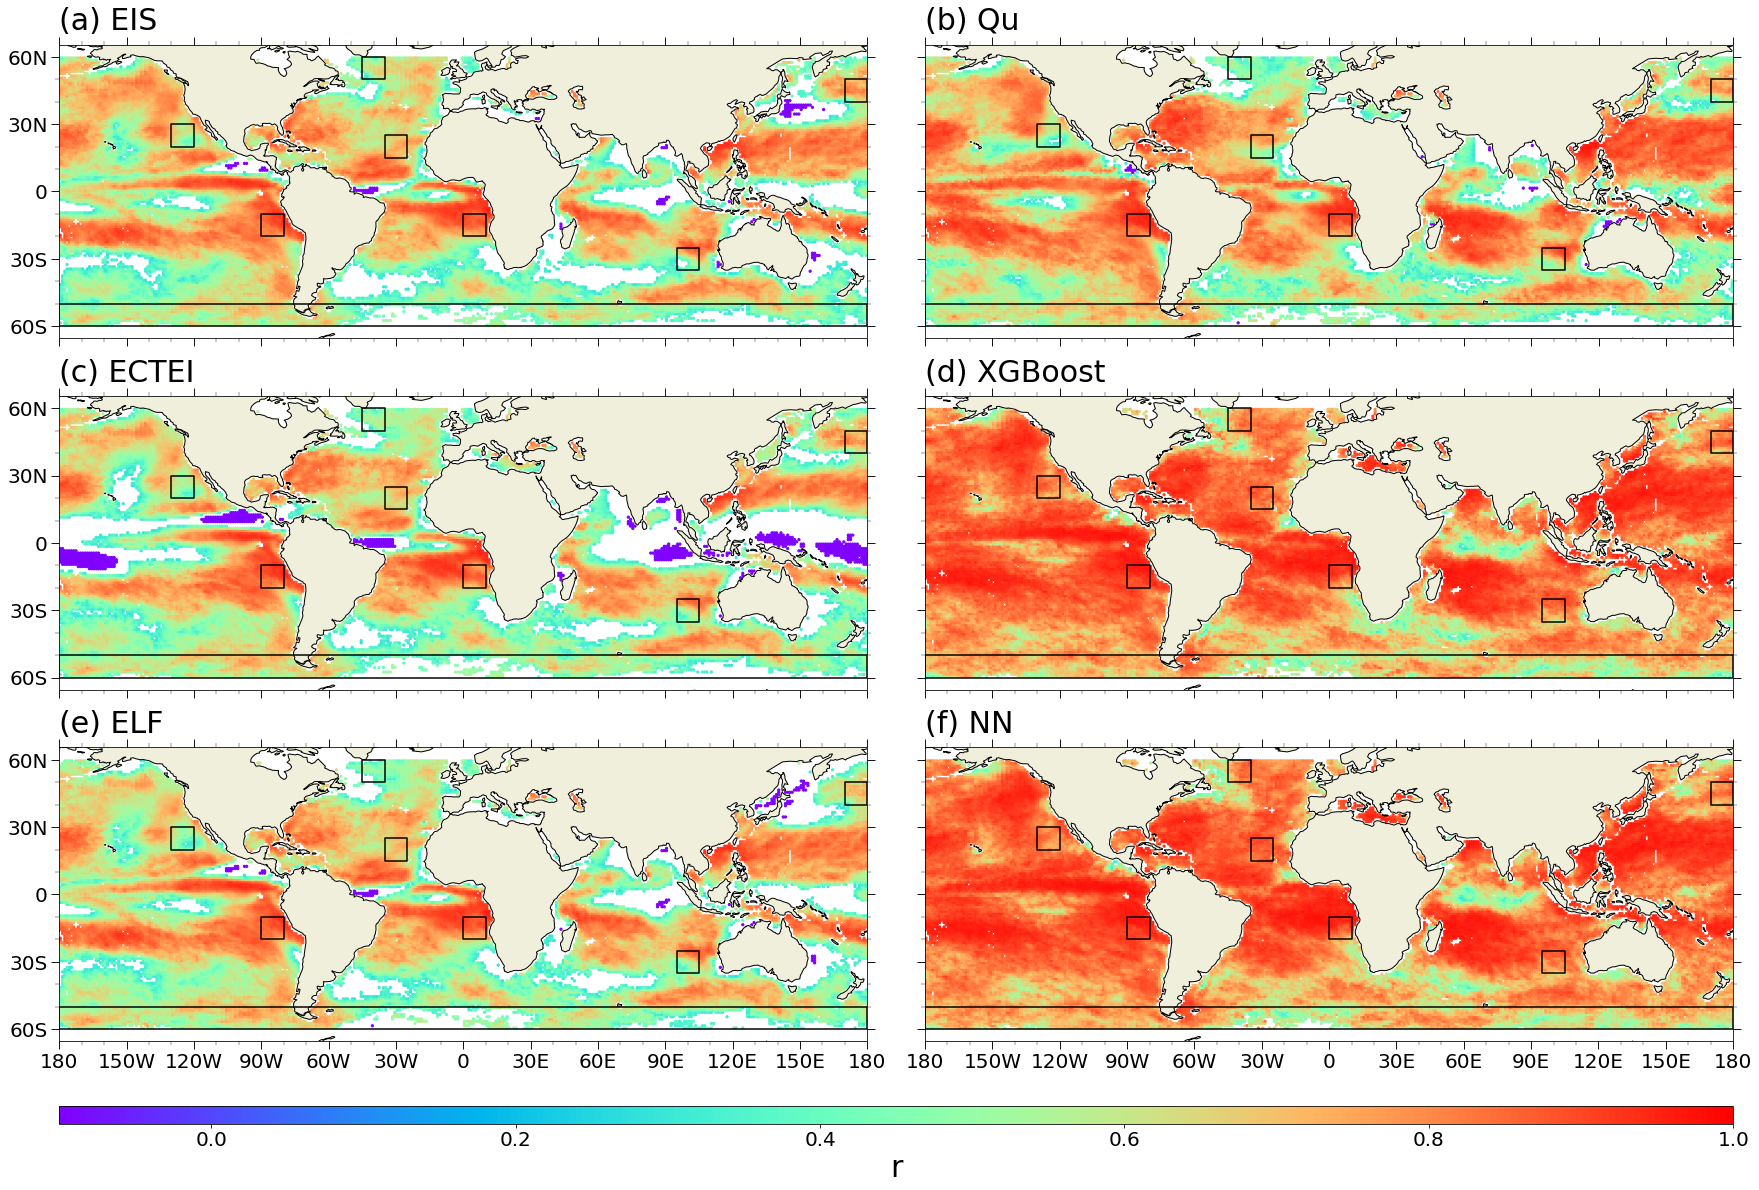

In [9]:
plt_dat1 = cor_space[(cor_space.p<=0.05)&(cor_space.model=='EIS')]
plt_dat2 = cor_space[(cor_space.p<=0.05)&(cor_space.model=='ECTEI')]
plt_dat3 = cor_space[(cor_space.p<=0.05)&(cor_space.model=='ELF')]

plt_dat4 = cor_space[(cor_space.p<=0.05)&(cor_space.model=='Qu')]
plt_dat5 = cor_space[(cor_space.p<=0.05)&(cor_space.model=='XGBoost')]
plt_dat6 = cor_space[(cor_space.p<=0.05)&(cor_space.model=='NN')]

plt_dats = [plt_dat1, plt_dat2, plt_dat3, plt_dat4, plt_dat5, plt_dat6]

import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import cm
import cartopy.feature as cfeature
import geocat.viz.util as gvutil
from shapely.geometry.polygon import LinearRing

fig = plt.figure(figsize=(30, 30))

projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
axgr = AxesGrid(fig,
                111,
                axes_class=axes_class,
                nrows_ncols=(3, 2),
                axes_pad=0.8,
                share_all=True,
                cbar_location="bottom",
                cbar_mode='single',
                direction = 'column',
                cbar_pad=0.1,
                cbar_size='3.0%',
                label_mode=''
                )  # note the empty label_mode


# Create a dictionary for common plotting options for both subplots
plot_option = dict(transform=projection,
                    cmap=cm.rainbow,
                    vmin=-0.1,
                    vmax=1.0,
                    )

def get_box(lon, lat):
    lons = [lon[0], lon[1], lon[1], lon[0]]
    lats = [lat[0], lat[0], lat[1], lat[1]]
    ring = LinearRing(list(zip(lons, lats)))
    return(ring)

ring1 = get_box([-90,-80], [-20, -10]) # Peruvian
ring2 = get_box([0, 10], [-20, -10])   # Namibian
ring3 = get_box([-130,-120], [20, 30]) # Californian
ring4 = get_box([95,105], [-35,-25])   # Australian
ring5 = get_box([-35, -25], [15, 25])  # Canarian

ring6 = get_box([170,180], [40,50])  # North Pacific
ring7 = get_box([-45,-35], [50,60])    # North Atlantic
ring8 = get_box([-180,180], [-60,-50]) # Circumpolar Ocean

ring = [ring1, ring2, ring3, ring4, ring5, ring6, ring7, ring8]
ti = ['(a) EIS', '(c) ECTEI', '(e) ELF', '(b) Qu', '(d) XGBoost', '(f) NN']

for i, (ax,plt_dat) in enumerate(zip(axgr,plt_dats)):


    p = ax.scatter(plt_dat.lon, plt_dat.lat, c=plt_dat.r, s=5, **plot_option)
    ax.annotate(ti[i], xy=(0.00, 1.05), xycoords='axes fraction', fontsize=30)
        
    if i <=1 or i == 3 or i == 4:
        plt.setp(ax.get_xticklabels(), visible=False)
    if i > 2:
        plt.setp(ax.get_yticklabels(), visible=False)
    
    # set colorbars
    if i == 2 or i == 5:
        ax.cax.colorbar(p)
    
    # plot boxes
    for ir in range(len(ring)):
        ax.add_geometries([ring[ir]], crs=projection, facecolor='none', edgecolor='black', lw=1.5)

    ax.coastlines()
    ax.add_feature(cfeature.LAND)

    gvutil.add_major_minor_ticks(ax, labelsize=20)

    gvutil.set_axes_limits_and_ticks(ax,
                                     xticks=np.linspace(-180, 180, 13),
                                     yticks=np.linspace(-60, 60, 5))

    ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))
    ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol=''))

    
for i, cax in enumerate(axgr.cbar_axes):
    cax.toggle_label(True)
    axis = cax.axis[cax.orientation]
    axis.label.set_size(30)
    axis.major_ticklabels.set_size(20)
  
    if i==0:
        axis.label.set_text(r'r')
    else:
        axis.label.set_text(r'r')        



In [10]:
df_new['season'] = ''
df_new.loc[df_new.index.month.isin([3,4,5]),   'season']='MAM'
df_new.loc[df_new.index.month.isin([6,7,8]),   'season']='JJA'
df_new.loc[df_new.index.month.isin([9,10,11]), 'season']='SON'
df_new.loc[df_new.index.month.isin([12,1,2]),  'season']='DJF'

lat = df_new.lat
lon = df_new.lon

OCN_index = (lat>=-60)&(lat<=60)
SO_index  = (lat>=-60)&(lat<-50)
SEP_index = ((lat>=-20)&(lat<-10)) & ((lon>=270)&(lon<280))
SEA_index = ((lat>=-20)&(lat<-10)) & ((lon>=0)&(lon<10))
SEI_index = ((lat>=-35)&(lat<-25)) & ((lon>=95)&(lon<105))
NEP_index = ((lat>=20)&(lat<30))   & ((lon>=230)&(lon<240))
NEA_index = (lat>=15)&(lat<25)     & ((lon>=325)&(lon<335))
NA_index  = (lat>=50)&(lat<60)     & ((lon>=315)&(lon<325))
NP_index  = (lat>=40)&(lat<50)     & ((lon>=170)&(lon<180))

df_new['regs'] = np.NaN
df_new.loc[SO_index,  'regs']='SO'
df_new.loc[SEP_index, 'regs']='SEP'
df_new.loc[SEA_index, 'regs']='SEA'
df_new.loc[SEI_index, 'regs']='SEI'
df_new.loc[NEP_index, 'regs']='NEP'
df_new.loc[NEA_index, 'regs']='NEA'
df_new.loc[NA_index,  'regs']='NA'
df_new.loc[NP_index,  'regs']='NP'

df_new['season'] = pd.Categorical(df_new['season'], ['DJF', 'MAM', 'JJA', 'SON'])
df_new['regs']   = pd.Categorical(df_new['regs'],   ['NA', 'NP', 'NEP', 'NEA', 'SEP', 'SEA', 'SEI', 'SO'])

In [11]:
rmse_seas = df_new.groupby('season').apply(get_rmse)
cor_seas = df_new.groupby('season').apply(get_cor)
rmse_seas.reset_index(level=[0,1], inplace=True)
cor_seas.reset_index(level=[0,1], inplace=True)

rmse_regs = df_new.groupby('regs').apply(get_rmse)
cor_regs = df_new.groupby('regs').apply(get_cor)
rmse_regs.reset_index(level=[0,1], inplace=True)
cor_regs.reset_index(level=[0,1], inplace=True)

In [12]:
# calculate the overall mse and r

rmse_all = get_rmse(df_new)
r_all   = get_cor(df_new)

rmse_all.reset_index(level=[0], inplace=True)
r_all.reset_index(level=[0], inplace=True)


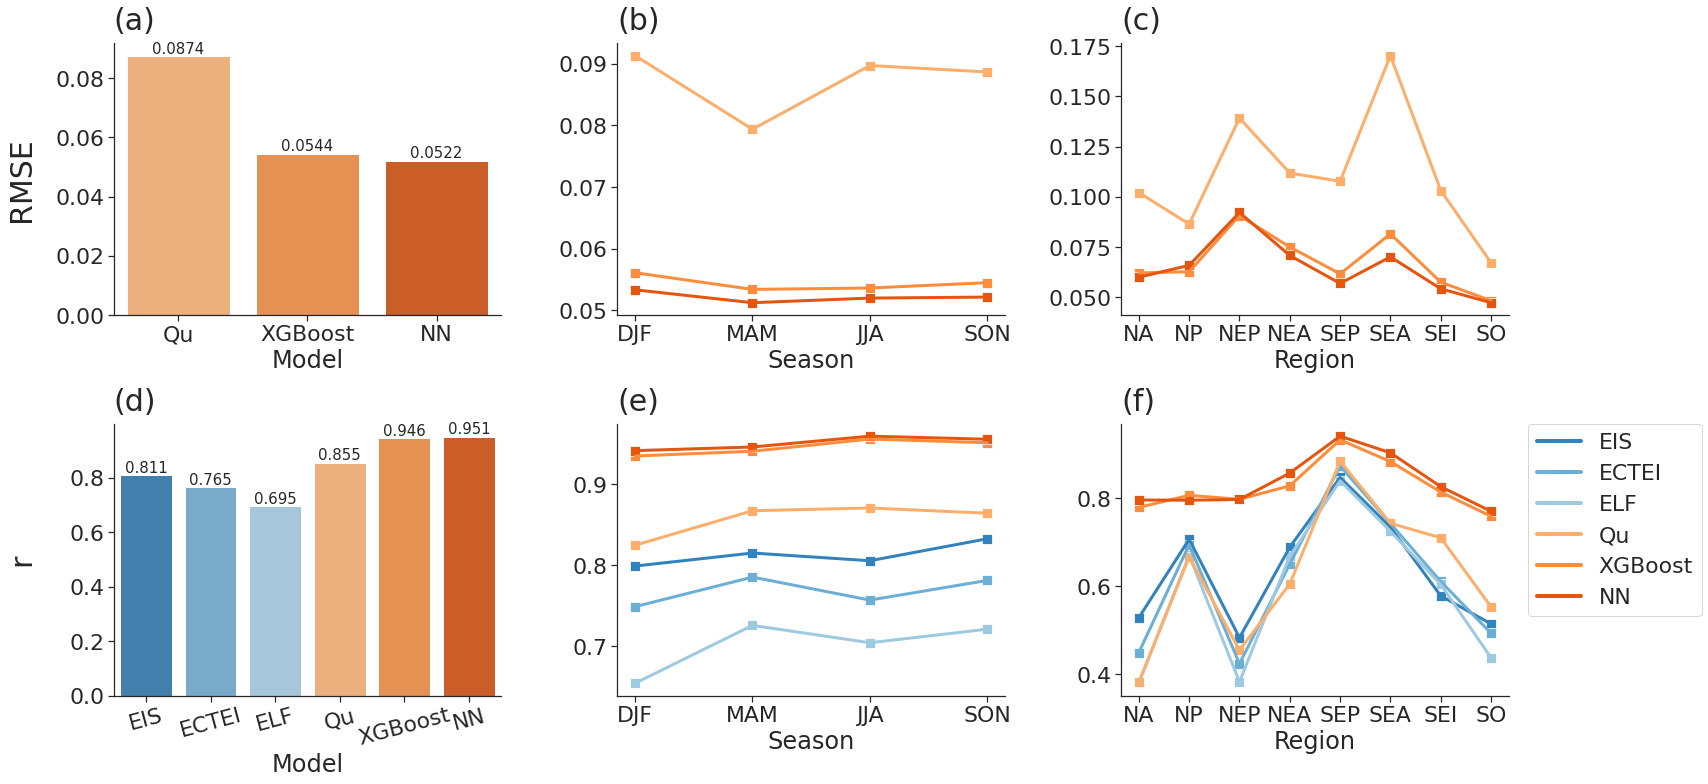

In [13]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale = 2.0)

fig = plt.figure(figsize=[25, 12])

gd  = (2, 3)
ax1 = plt.subplot2grid(gd, (0, 0))
ax2 = plt.subplot2grid(gd, (0, 1))
ax3 = plt.subplot2grid(gd, (0, 2))
ax4 = plt.subplot2grid(gd, (1, 0))
ax5 = plt.subplot2grid(gd, (1, 1))
ax6 = plt.subplot2grid(gd, (1, 2))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

pal = sns.color_palette("tab20c")
palette1 = [pal[6], pal[5], pal[4]]
palette2 = sns.color_palette("tab20c")[0:3] + palette1

### plot1 ###
g1 = sns.barplot(x="model", y="val", data=rmse_all, ax=ax1,
                 palette=palette1)
g1.set(xlabel='Model', ylabel='')

### plot2 ###
g2 = sns.lineplot(x="season", y="val", hue="model", 
                 linewidth=3, 
                 data=rmse_seas,
                 ax=ax2,
                 palette=palette1)
g2 = sns.scatterplot(x="season", y="val", hue="model",
                data=rmse_seas,
                ax=ax2,
                palette=palette1,
                s = 100,
                marker = 's')
g2.set(xlabel='Season', ylabel='')
g2.get_legend().remove()

### plot3 ###
g3 = sns.lineplot(x="regs", y="val", hue="model", 
                 linewidth=3, 
                 data=rmse_regs,
                 ax=ax3,
                 palette=palette1)
g3 = sns.scatterplot(x="regs", y="val", hue="model",
                data=rmse_regs,
                ax=ax3,
                palette=palette1,
                s = 100,
                marker = 's')
g3.set(xlabel='Region', ylabel='')
g3.get_legend().remove()

### plot4 ###
g4 = sns.barplot(x="model", y="r", data=r_all, ax=ax4,
                 palette=palette2)
g4.set(xlabel='Model', ylabel='')
g4.tick_params(axis='x', rotation=15)

### plot5 ###
g5 = sns.lineplot(x="season", y="r", hue="model", 
                 linewidth=3, 
                 data=cor_seas,
                 ax=ax5,
                 palette=palette2)
g5 = sns.scatterplot(x="season", y="r", hue="model",
                data=cor_seas,
                ax=ax5,
                palette=palette2,
                s = 100,
                marker = 's')
g5.set(xlabel='Season', ylabel='')
g5.get_legend().remove()

### plot6 ###
g6 = sns.lineplot(x="regs", y="r", hue="model", 
                 linewidth=3, 
                 data=cor_regs,
                 ax=ax6,
                 palette=palette2)
g6 = sns.scatterplot(x="regs", y="r", hue="model",
                data=cor_regs,
                ax=ax6,
                palette=palette2,
                s = 100,
                marker = 's',
                legend=False)
g6.set(xlabel='Region', ylabel='')

leg = g6.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
for line in leg.get_lines():
    line.set_linewidth(4.0)

######## add title ##########3
ti = ['(a)','(b)','(c)','(d)','(e)','(f)']

for i, ax in enumerate(axes):
    ax.annotate(ti[i], xy=(0.00, 1.05), xycoords='axes fraction', fontsize=30)

ax1.set_ylabel('RMSE', fontsize=30)
ax1.get_yaxis().set_label_coords(-0.2, 0.5)

ax4.set_ylabel('r', fontsize=30)
ax4.get_yaxis().set_label_coords(-0.2, 0.5)

######## add bar values ##########3
ax1.bar_label(ax1.containers[0], fmt='%.4f', size=15)
ax4.bar_label(ax4.containers[0], fmt='%.3f', size=15)
    
plt.subplots_adjust(hspace=0.4, wspace=0.3)  

  
plt.show()